# Привет!

Здесь ты будешь выполнять тестовое задание на позицию стажера Data Analyst в Napoleon IT.

Критерии оценки:
1. Логичность и последовательность суждений
2. Полнота ответов на поставленные задачи
3. Чистота и читабельность кода

В первом пункте потребуется использовать python: pandas, numpy и библиотеки визуализации: plotly/matplotlib/seaborn  
Во втором будет предложено написать несколько SQL-запросов

### Описание задачи


В большом городе N существуют магазины одной сети. Чтобы поддерживать самые низкие цены во всей сети, сотрудники магазинов посещают конкурентов и фотографируют пересекающиеся товары.  
Некая программа собирает все фотографии, распознает товары и цены, возвращает сотруднику. Распознавание товаров происходит с помощью моделей машинного обучения. Первая модель распознает товар, вторая - цену. Далее сотрудник, в свою очередь, подтверждает то, что распознала модель или привязывает к другому товару, если модель распознала некорректно. Далее все данные записываются в БД.  

  
Главная метрика, по которой происходит оценка эффективности модели - **метрика распознавания** - означает, что распознался и товар, и цена. Чтобы оценить эффективность каждой модели, можно рассчитать распознавание только цены или распознавание только продукта.  
  
   
   
В системе произошел сбой и все данные для обучения _модели распознавания товаров_ потерялись.  
Нужно заново собрать список товаров для обучения модели и обосновать свой выбор. 

# PYTHON

### Разведочный анализ данных

Ознакомься с представленным датасетом - выгрузкой данных из БД, изучи все столбцы и найди закономерности в данных

<div class="alert alert-block alert-info">
<b>Примечание</b> 
<br>Два последних символа в целой части значений полей predicted_product_price и confirmed_product_price - копейки
</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
seed = 21
ds_path = Path('./')

In [3]:
def calculate_quality(df):
    return (df.observations-df.prediction_is_missed)/df.observations

In [4]:
df = pd.read_csv(ds_path/'Test_dataset.csv')
df['dt_create'] = pd.to_datetime(df.dt_create)

df_analysis = df.copy(True) # Размер таблицы относительно небольшой, лучше сделаем копию для анализа данных
df.head(3)

,dt_create,shop_id,competitor_id,prod_cat_name,prod_group_name,predicted_product_id,predicted_product_price,confirmed_product_id,confirmed_product_price
0,2023-01-30,3505,1,алкоголь,"вина, винные напитки",9291.0,43999.0,9291,43999
1,2023-01-30,1843,21,алкоголь,слабоалкогольные напитки,2020719.0,6999.0,10653,6999
2,2023-01-30,966,0,алкоголь,"вина, винные напитки",9377.0,53999.0,9377,53999


#### Отступление по заданию
Не могу скрыть того, что описание задачи меня немного смутило. Сказано, что у нас есть некоторая модель для распознавания товара (поле predicted_product_id) и цены (поле predicted_product_price). Они скорее всего работают на основе ансамбля детекции и OCR, что, естественно, учится на фотографиях и метках. То есть данные из "test_dataset" могут быть применены лишь для модели, которая создает эмбединги для ансамбля. Но этот момент оставлю, как допущение (тестовое задание, как никак))

#### Начнем с рассмотрения датасета

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   dt_create                150000 non-null  datetime64[ns]
 1   shop_id                  150000 non-null  int64         
 2   competitor_id            150000 non-null  int64         
 3   prod_cat_name            150000 non-null  object        
 4   prod_group_name          150000 non-null  object        
 5   predicted_product_id     146106 non-null  float64       
 6   predicted_product_price  146039 non-null  float64       
 7   confirmed_product_id     150000 non-null  int64         
 8   confirmed_product_price  150000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 10.3+ MB


In [6]:
# Ну и дела, пропуски в полях предсказаний!
na_count = df.isna().sum()
na_count[na_count.values != 0]

predicted_product_id       3894
predicted_product_price    3961
dtype: int64

In [7]:
# Ну, в целом никаких страшных расхождений нет (модель не приписывала несколько лишних ноликов))
df.describe().loc[:, ['predicted_product_price', 'confirmed_product_price', 'competitor_id']]

,predicted_product_price,confirmed_product_price,competitor_id
count,1.460390e+05,1.500000e+05,150000.00000
mean,2.783829e+04,2.817505e+04,9.87194
std,3.870860e+04,3.970674e+04,28.66882
min,2.990000e+02,1.420000e+02,0.00000
25%,6.690000e+03,6.699000e+03,0.00000
50%,1.369900e+04,1.399900e+04,1.00000
75%,3.699900e+04,3.709225e+04,3.00000
max,1.699999e+06,1.699999e+06,379.00000


In [8]:
# Для дальнейшего анализа специально сделаем доп. столбец
df_analysis['prediction_is_missed'] = df_analysis.isnull().any(axis=1).astype(int)
df_analysis.query('prediction_is_missed == 1').head(3)

,dt_create,shop_id,competitor_id,prod_cat_name,prod_group_name,predicted_product_id,predicted_product_price,confirmed_product_id,confirmed_product_price,prediction_is_missed
62,2023-01-30,2570,0,пиво,пиво лицензионное,NaN,NaN,10940,6999,1
135,2023-01-30,411,2,алкоголь,"виски, висковые напитки, бурбоны",NaN,NaN,2357254,42856,1
139,2023-01-30,846,0,алкоголь,"вина, винные напитки",NaN,NaN,9053,48999,1


['алкоголь' 'продукты' 'пиво' 'нон-фуд' 'товары для мониторинга'
 'сигареты' 'rrp и атп']


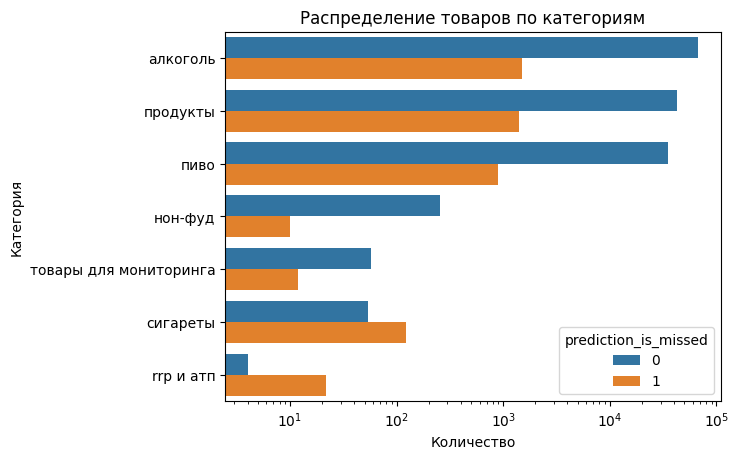

In [9]:
# Посмотрим на распределение товаров по категориям
print(df['prod_cat_name'].unique())

g = sns.countplot(y='prod_cat_name', data=df_analysis, hue='prediction_is_missed')
g.set_xscale('log')

g.set_title('Распределение товаров по категориям')
g.set_ylabel('Категория')
g.set_xlabel('Количество')
plt.show()

Видимо, данные собираются как по обычным продуктовым магазинам, так и по алкогольным (иначе бы у нас не было такого количества записей по продуктовым/алкогольным товарам). Можно также отметить, что большая часть товаров небольшого размера (категории атп, сигареты) не распознаются в среднем чаще, чем товары других категорий

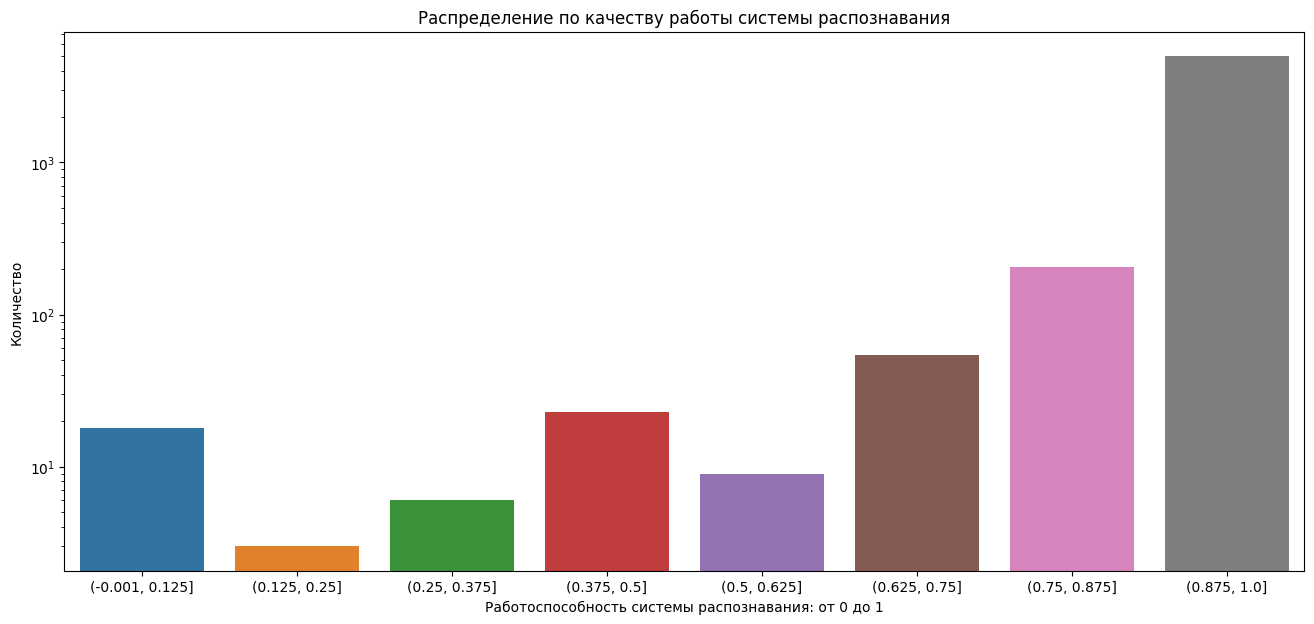

In [10]:
# Проверим качество измерений в магазинах
df_analysis['observations'] = 1

# OQ - observations quality
df_OQ = df_analysis.loc[:, ['shop_id', 'prediction_is_missed', 'observations']].groupby('shop_id').aggregate(sum)
df_OQ['acc'] = calculate_quality(df_OQ)
df_OQ.sort_values(by='acc', inplace=True)
quality_bins = pd.cut(df_OQ.acc, 8)

fig, ax = plt.subplots(figsize=(16, 7))

g = sns.countplot(x=quality_bins)
g.set_yscale('log')

g.set_title('Распределение по качеству работы системы распознавания')
g.set_xlabel('Работоспособность системы распознавания: от 0 до 1')
g.set_ylabel('Количество')
plt.show()

In [11]:
# Покажем магазины с наихудшим качеством работы системы распознавания (где было хотя бы 25 наблюдений)
# Научите этих сотрудников сканировать) (эти записи в следующем пункте нужно будет проанализировать)
df_OQ.query('observations > 25').head(10)

,prediction_is_missed,observations,acc
shop_id,,,
848,17,43,0.604651
2268,10,30,0.666667
2011,10,31,0.677419
1569,10,35,0.714286
1521,10,36,0.722222
1867,9,33,0.727273
2596,7,27,0.740741
161,15,61,0.754098
2679,6,26,0.769231


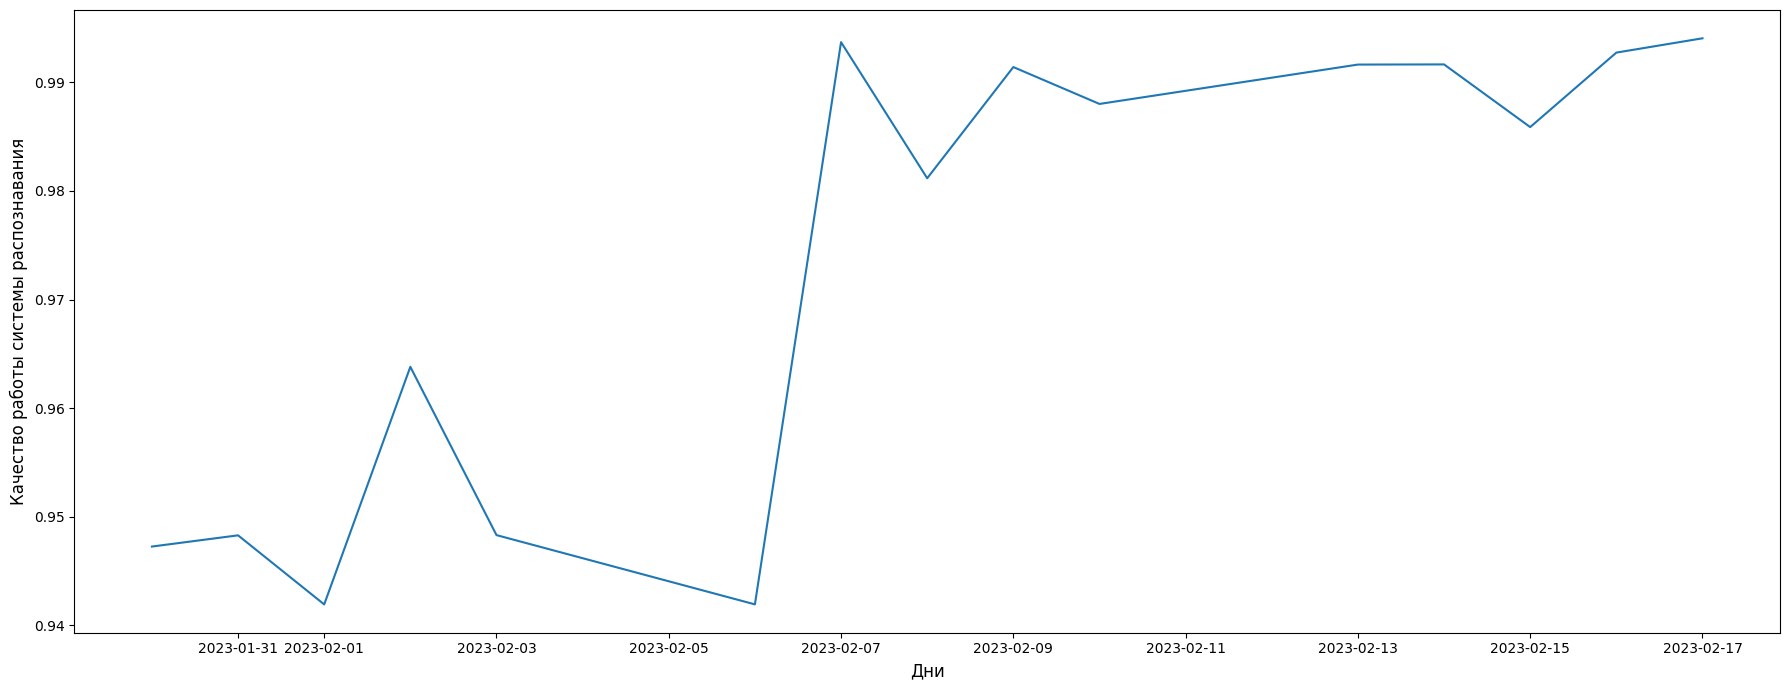

In [12]:
# А что там по датам? Может в некоторые дни система работала хуже?

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
df_dates = df_analysis.loc[:, ['observations', 'prediction_is_missed', 'dt_create']].groupby('dt_create').sum()
g = sns.lineplot(x=df_dates.index, y=calculate_quality(df_dates))

g.set_ylabel('Качество работы системы распознавания', size=12)
g.set_xlabel('Дни', size=12)
plt.tight_layout()

#### Про качество распознавания
Как мы видим, просадки по качеству распознаваний отсутствуют, что исключает возможность поломки оборудования: каждый день количество непроизведенных распознаваний было приблизительно соизмеримо с количеством произведенных распознаваний. Также в среднем качество распознаваний в каждом магазине довольно высоко за исключением магазинов с маленьким количеством измерений (гр. "распределение по качеству измерений")


In [13]:
# Теперь проверим качество работы системы распознавания в магазинах-конкурентах
df_competitors = df_analysis.loc[:, ['competitor_id', 'prediction_is_missed', 'observations']]
df_competitors = df_competitors.groupby('competitor_id').aggregate(sum)
df_competitors['acc'] = calculate_quality(df_competitors)

df_competitors.describe()

,prediction_is_missed,observations,acc
count,380.000000,380.000000,380.000000
mean,10.423684,394.736842,0.905727
std,72.641905,3275.832606,0.193135
min,0.000000,1.000000,0.000000
25%,0.000000,3.000000,0.918321
50%,1.000000,13.500000,0.979622
75%,3.000000,60.000000,1.000000
max,1151.000000,41045.000000,1.000000


Тут особо и сказать нечего: у большей части конкурентов (>75%) распознавание в целом работало нормально (с 90% вероятностью). При этом меня волнует, что 25% всех конкурентов - это большая часть всех наших наблюдений (речь про competitors с id близкими к нулю). Если качество, которое было раньше, нас удовлетворяет, то магазины с маленьким количеством наблюдений лучше выбросить из обучающей выборки в дальнейшем для повышения **стабильности** модели.

In [14]:
# Определим важные признаки c помощью xgboost и заполним поля-пропуски (он для этого прекрасно подходит)

df_analysis['count_of_digits'] = df_analysis.confirmed_product_price.astype(str).str.len()
df_analysis['target'] = (df_analysis.predicted_product_price == df_analysis.confirmed_product_price).astype(int)


df_train = df_analysis.loc[:, ['count_of_digits', 'prod_cat_name', 'prod_group_name', 'target', 'prediction_is_missed']]
df_predict = df_train.query('prediction_is_missed == 1').drop(['prediction_is_missed', 'target'], axis=1)
df_train = df_train.drop(df_predict.index).drop('prediction_is_missed', axis=1)


# категориальные признаки закодируем OHE
ohe = OneHotEncoder()
ohe.fit(df_analysis.loc[:, ['prod_cat_name', 'prod_group_name']])

def OHE(df):
    global ohe
    return ohe.transform(df.loc[:, ['prod_cat_name', 'prod_group_name']])

target = df_train.pop('target').values

ohe_df_train = OHE(df_train).toarray()

predict_indexes = df_predict.index
ohe_df_predict = OHE(df_predict).toarray()

# обьединим признаки
df_train = np.concatenate([ohe_df_train, df_train['count_of_digits'].values.reshape(-1, 1)], axis=1)
df_predict = np.concatenate([ohe_df_predict, df_predict['count_of_digits'].values.reshape(-1, 1)], axis=1)

# проведем нормализацию. Без нее моделькам очень плохо
scaler = StandardScaler()
X = scaler.fit_transform(df_train)
X_predict = scaler.fit_transform(df_predict)


In [15]:
# Разобьем на выборки для определения качества модели
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=seed)

clf = XGBClassifier(booster='gbtree', seed=seed)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_test_pred)}')
print(f'f1: {f1_score(y_test, y_test_pred)}')

accuracy: 0.9566214735688853
f1: 0.9778182391148305


Точность обученной модели и f1-мера довольно высоки, так что XGBClassifier смело можно использовать для заполнения пропусков. Потери от меньшего количества данных (если записи выбросить) при обучении столь сложного ансамбля для распознавания цены и товара будут намного выше (поскольку такие модели требуют много данных: каждая уникальная запись на счету!), чем если эти данные будут искусственным образом дополнены другой моделью.

In [16]:
# Восстановим имена признаков
df_train_cols = []
for curr_l in ohe.categories_:
    for c in curr_l:
        df_train_cols.append(c)

df_train_cols.append('Размер числа, характеризующего стоимость товара')

important_features = pd.DataFrame(
    data={
        'feature':  df_train_cols,
        'importance': clf.feature_importances_
    }
).sort_values(by='importance', ascending=False)

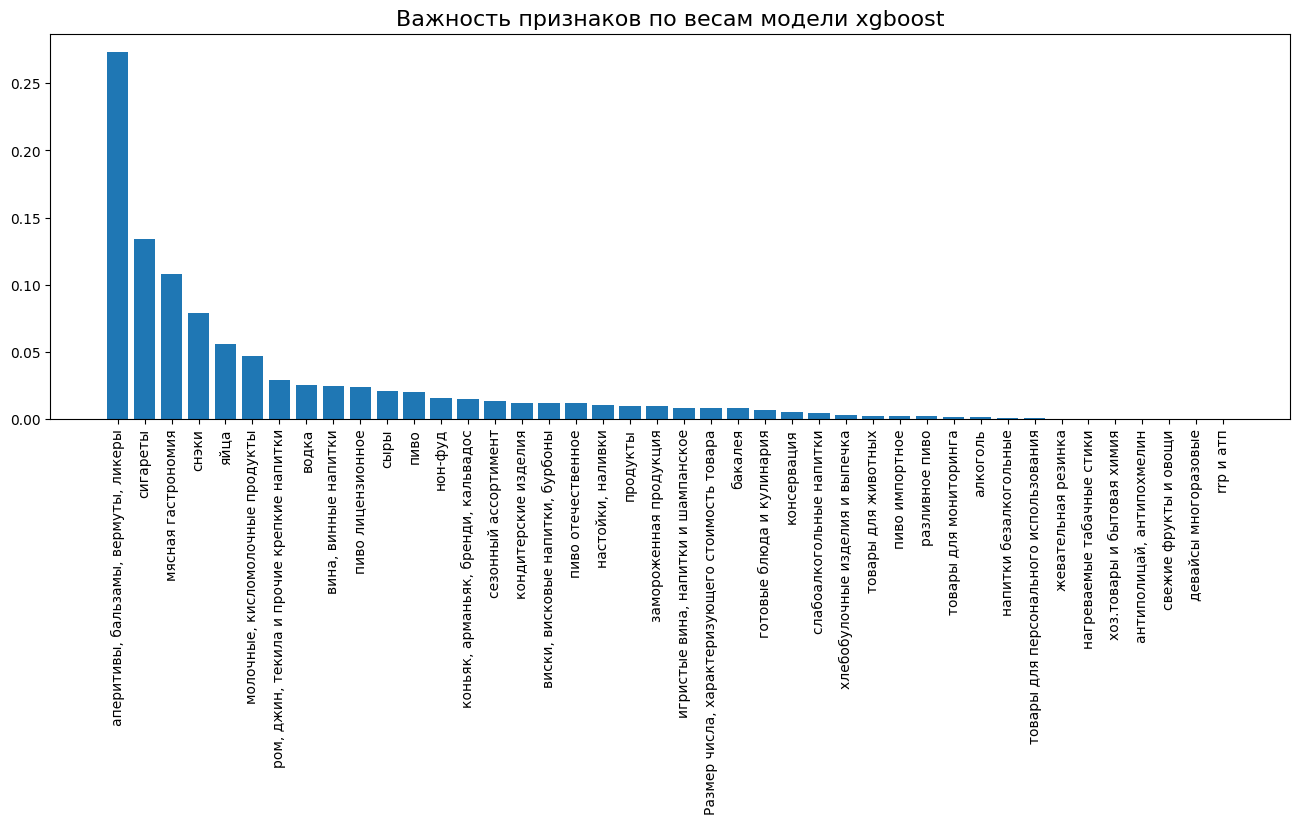

In [17]:
fig, ax = plt.subplots(figsize=(16, 5))
plt.bar(x=important_features['feature'], height=important_features['importance'])
plt.title('Важность признаков по весам модели xgboost', size=16)
plt.xticks(rotation='vertical')
plt.show()

Для определения важности ряда признаков была обучена модель градиентного бустинга XGBoost. Как целевая переменная - признак "корректно ли будет проведено распознавание", а как датасет для обучения - количество цифр в стоимости продукта (чем больше стоимость, тем больше итоговое число и выше шанс, что одна из цифр будет считана неверно) и категории/подкатегории товаров. Результат работы алгоритма дает нам следующую информацию: категории продуктов, **упаковка которых мала, сложна по своей форме** (сигареты, снэки, мясная гастрономия, молочные продукты), или **цена которых высока** (алкоголь) - **являются проблемой** для текущей системы распознавания (что, кстати, отражается на графике "распределение товаров")

In [18]:
# Как уже было сказано, выбрасывать большое количество записей мы не можем: каждая на счету
# Поэтому заполним выбросы обученой моделью: если та скажет, что вероятность правильного определения высока,
# то поставим для predicted_product_price и predicted_product_id верные значения
correct_criteria = clf.predict_proba(X_predict)[:, 1] > 0.84
df.loc[predict_indexes, 'predicted_product_id'] = df.loc[predict_indexes, 'predicted_product_id'].mask(correct_criteria, df.loc[predict_indexes, 'confirmed_product_id'])
df.loc[predict_indexes, 'predicted_product_price'] = df.loc[predict_indexes, 'predicted_product_price'].mask(correct_criteria, df.loc[predict_indexes, 'confirmed_product_price'])
df.dropna(inplace=True)

### Описательная аналитика

Посчитай отдельные метрики распознавания и общую:
1. confirmed_product_id == predicted_product_id - модель правильно распознала товар
2. confirmed_product_price == predicted_product_price - модель правильно распознала цену 

Проверь все следующие гипотезы:  
- Все конкуренты одинаково распознаются +
- В распознавании цены есть проблемы  
- Поле dt_create влияет на общую метрику распознавания  
- Общая метрика распознавания зависит от магазина сотрудника  

Ответы на вопросы представляйте в формате "гипотеза - исследование - вывод"  

Выбери 2 гипотезы и предположи, _почему_ ты получил такой вывод 

In [19]:
# Посчитаем т.н. "метрики"
df_analysis['P_pid_correct'] = (df_analysis.confirmed_product_id == df_analysis.predicted_product_id)
df_analysis['P_pprice_correct'] = (df_analysis.confirmed_product_price == df_analysis.predicted_product_price)
df_analysis['P_prediction_correct'] = (df_analysis.P_pprice_correct & df_analysis.P_pid_correct)

### Гипотеза - "Все конкуренты одинаково распознаются"

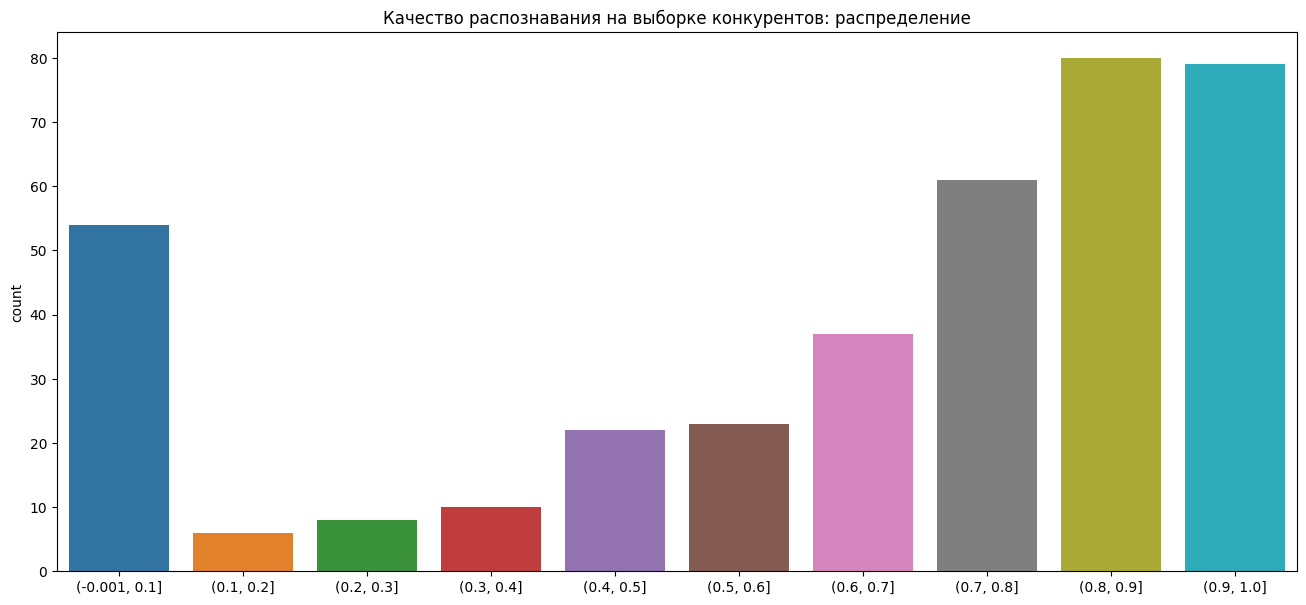

In [20]:
hypo1 = df_analysis.loc[:, ['competitor_id', 'P_pid_correct', 'P_pprice_correct', 'P_prediction_correct', 'observations']]
hypo1 = hypo1.groupby('competitor_id').sum()
hypo1['acc'] = hypo1.P_prediction_correct/hypo1.observations

hypo_data = pd.cut(sorted(hypo1.acc), 10)

fig, ax = plt.subplots(figsize=(16, 7))
g = sns.countplot(x=hypo_data)
g.set_title('Качество распознавания на выборке конкурентов: распределение')
plt.show()

In [21]:
print(f'Информация по качеству распознавания: \n{hypo1.describe().acc}')

# Проверим, какие конкуренты по качесту распознавания так сильно проигрывают
quant = np.quantile(hypo1.acc, q=0.51)
print(
    'Среднее количество наблюдений у конкурентов с плохим качеством распознавания:',
    round(hypo1.query(f'acc < {quant}').observations.mean())
)

Информация по качеству распознавания: 
count    380.000000
mean       0.648019
std        0.323238
min        0.000000
25%        0.500000
50%        0.750000
75%        0.875845
max        1.000000
Name: acc, dtype: float64
Среднее количество наблюдений у конкурентов с плохим качеством распознавания: 36


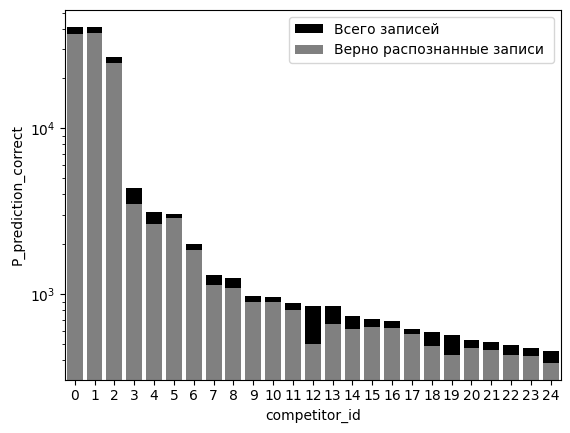

In [22]:
# Возьмем 25 самых крупных конкурентов
hypo_data = hypo1.sort_values(by='observations', ascending=False)[:25]

fig, ax = plt.subplots()
g = sns.barplot(
    data=hypo_data,
    x=hypo_data.index,
    y='observations',
    color='black',
    ax=ax,
    label='Всего записей'
)

sns.barplot(
    data=hypo_data,
    x=hypo_data.index,
    y='P_prediction_correct',
    color='gray',
    ax=ax,
    label='Верно распознанные записи '
)

g.legend()
g.set_yscale('log')

#### Вывод:
Эта гипотеза в корне несостоятельна: стандартное отклонение (для соотношения "кол-во верных распознаваний/кол-во всех распознаваний") велико. Даже у конкурентов с большим количеством наблюдений есть разница по качеству распознаваний (так, конкуренты с id 3,4,12,13,18,19 выделяются на фоне других "больших" конкурентов [id 0, 1, 2, 5 и другие]). 

#### Почему так может быть?
Из клетки с информацией по качеству распознавания было выяснено, что большая часть конкурентов с плохим качеством - это небольшие магазины, о чем сведетельствует небольшое количество наблюдений в оных. Есть вероятность, что такие магазины плохо работают с маркировкой своих товаров. Хотя имеет место быть и халатность(или необученность) работников нашей сети (см: конкурент с id 12)

### Гипотеза - "В распознавании цены есть проблемы"

In [23]:
# Неплохое качество, кстати!
print(f'Всего верно распознано {df_analysis.P_pprice_correct.sum()/len(df_analysis) * 100:.2f}% ценников')

Всего верно распознано 93.13% ценников


In [24]:
# Посмотрим, что влияет ли размер ценника на верное распознавание
hypo2 = df_analysis.loc[:, ['P_pprice_correct', 'count_of_digits', 'observations', 'prediction_is_missed']].groupby('count_of_digits').sum()
hypo2['acc'] = hypo2.P_pprice_correct/hypo2.observations
hypo2

,P_pprice_correct,observations,prediction_is_missed,acc
count_of_digits,,,,
3,22,44,2,0.500000
4,57629,61469,1700,0.937529
5,77747,83632,2176,0.929632
6,4290,4840,83,0.886364
7,9,15,0,0.600000


В целом заметна тенденция на ухудшение распознавания. А результаты системы распознавания для товаров с трехзначной стоимостью могут быть обьяснены тем, что модель недостаточно хорошо обучилась в связи с дисбалансом классов.

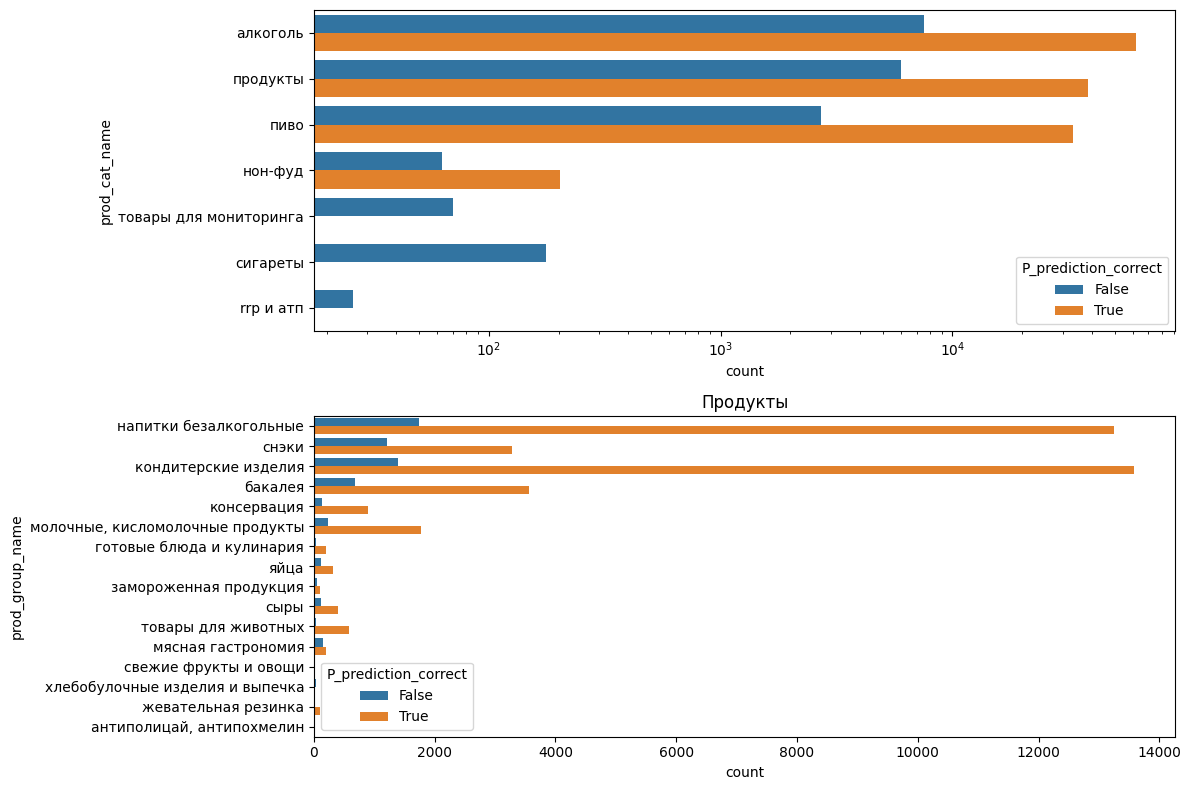

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
g = sns.countplot(data=df_analysis, y='prod_cat_name', hue='P_prediction_correct', ax=axs[0])
g.set_xscale('log')

g2 = sns.countplot(data=df_analysis.query('prod_cat_name == "продукты"'), y='prod_group_name', hue='P_prediction_correct', ax=axs[1])
g2.set_title('Продукты')
plt.tight_layout()

#### Вывод:
В целом система распознавания цены работает относительно нормально (потому что среднее качество высоко). Единственное, у нее есть проблемы с распознаванием продуктов с большой ценой и товаров с небольшой упаковкой сложной формы (снэки, сигареты, кондитерка, мясная гастрономия, rpr и атп)

#### Почему так может быть?
Как мы видим, в выборке преобладают товары среднего и большого размера. Это значит, что при обучении модель (ансамбль?) не смогла выявить все закономерности для товаров маленького размера (тех же сигарет). В целом, эта проблема решается большим количеством способов (от балансировки классов с помощью удаления записей преобладающего класса/дубликации записей меньшего класса до выбора другого loss/а), но это выходит за рамки тестового задания.

### Поле dt_create влияет на общую метрику распознавания

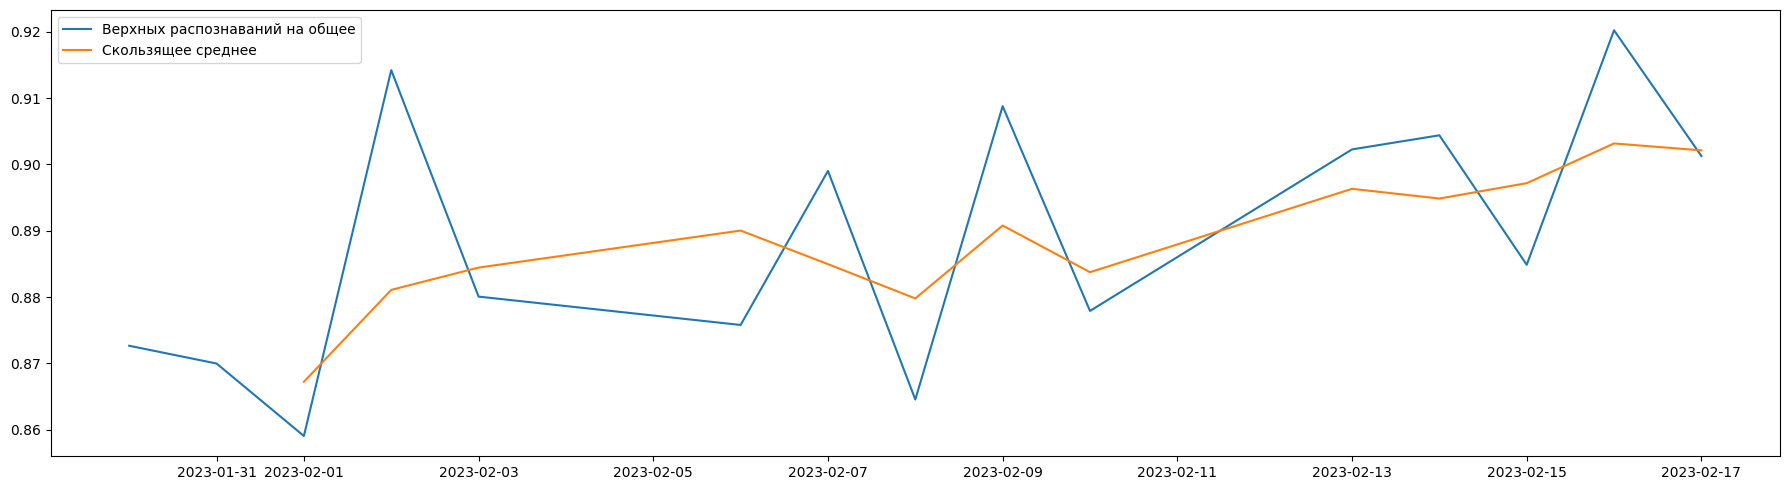

In [26]:
hypo3 = df_analysis.loc[:, ['P_prediction_correct', 'dt_create', 'observations']].groupby('dt_create').sum()
hypo3['acc'] = hypo3.P_prediction_correct/hypo3.observations
hypo3['day'] = hypo3.index.day_name()

rolling_mean = hypo3.acc.rolling(window=3).mean()

fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(hypo3.acc, label='Верхных распознаваний на общее')
ax.plot(rolling_mean, label='Скользящее среднее')

plt.legend()
plt.tight_layout()

In [27]:
hypo3.groupby('day').mean().loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]

,P_prediction_correct,observations,acc
day,,,
Monday,8802.000000,9962.333333,0.883569
Tuesday,9041.333333,10148.666667,0.891128
Wednesday,7733.666667,8895.666667,0.869491
Thursday,10060.666667,11002.333333,0.914399
Friday,8855.666667,9991.000000,0.886412


### Вывод:
Действительно, наблюдается небольшое влияние dt_create на общую метрику распознавания. Так например, проглядывается тенденция на повышение качества распознавания со временем (от первого дня, до последнего). Возможно это связано с дообучением модели. А еще в последний рабочий день недели (справедливо для каждой недели*) сотрудники магазинов хуже оперируют нашей моделью.

### Гипотеза - "Общая метрика распознавания зависит от магазина сотрудника"

Сотрудники 75% магазинов совершили > 17.0 сканирований


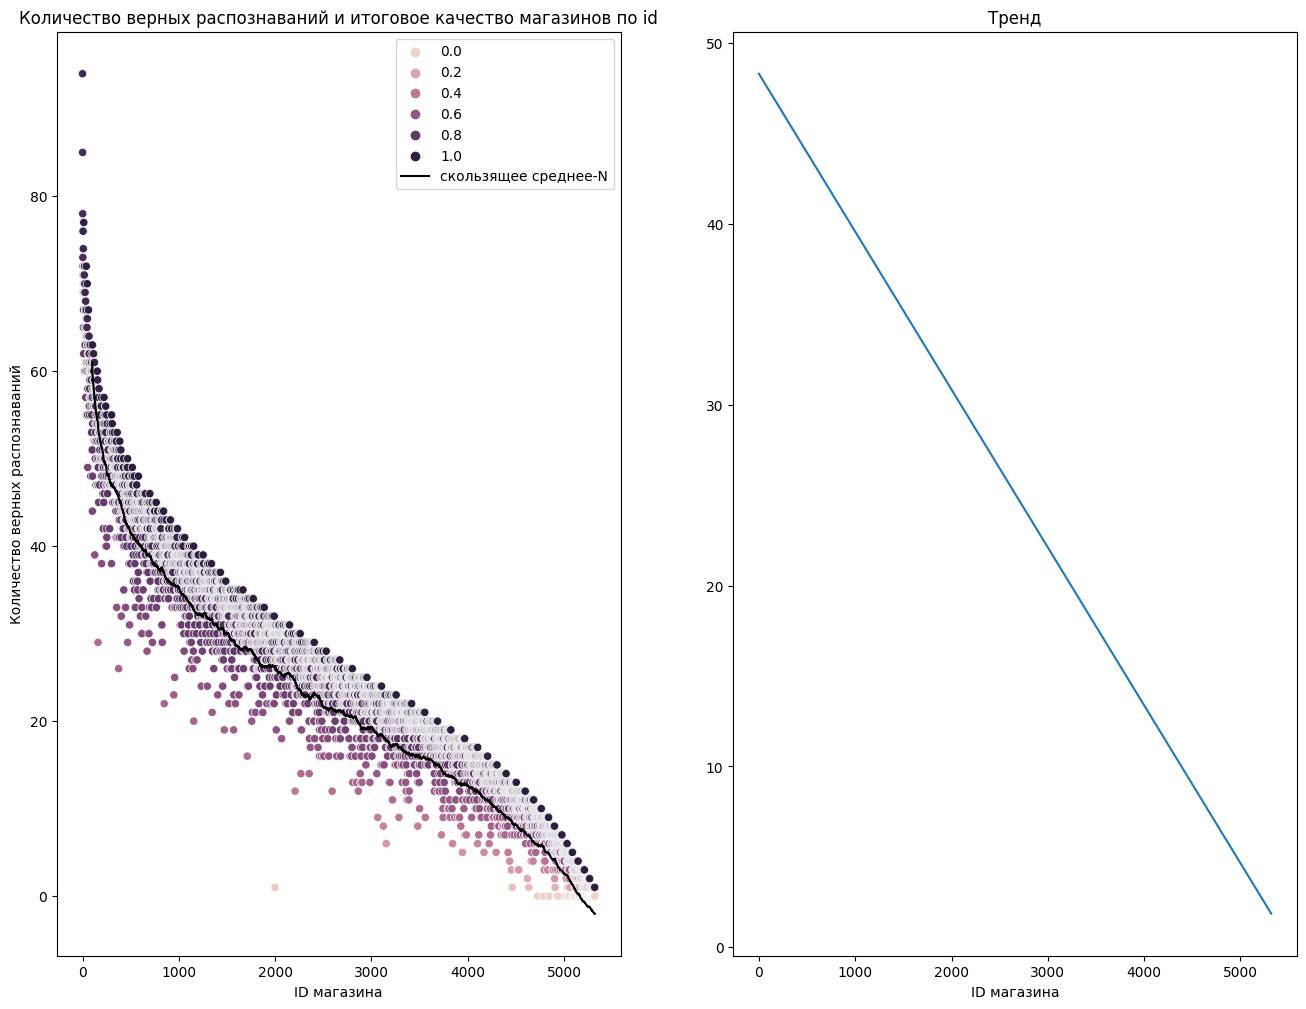

In [28]:
N = 3

hypo4 = df_analysis.loc[:, ['observations', 'P_prediction_correct', 'shop_id']].groupby('shop_id').sum()
hypo4['acc'] = hypo4.P_prediction_correct/hypo4.observations

rolling = hypo4.P_prediction_correct.rolling(window=100).mean()
shift = np.quantile(hypo4.observations, 0.25)
print(f'Сотрудники 75% магазинов совершили > {shift} сканирований')


fig, axs = plt.subplots(1, 2, figsize=(16, 12))
g = sns.scatterplot(x=hypo4.index, y=hypo4.P_prediction_correct, ax=axs[0], hue=hypo4.acc)
sns.lineplot(x=rolling.index, y=rolling.values-N, color='black', ax=axs[0], label='скользящее среднее-N')

axs[0].set_ylabel('Количество верных распознаваний')
axs[0].set_xlabel('ID магазина')
axs[0].legend()
axs[0].set_title('Количество верных распознаваний и итоговое качество магазинов по id')

# Кажется, что чем больше id магазина, тем меньше наблюдений было сделано
# его сотрудниками и наблюдения эти худшего качества

reg = LinearRegression()
reg.fit(hypo4.index.values.reshape(-1, 1), hypo4.P_prediction_correct)

sns.lineplot(x=rolling.index, y=reg.predict(rolling.index.values.reshape(-1, 1)), ax=axs[1])
axs[1].set_ylabel(None)
axs[1].set_xlabel('ID магазина')
axs[1].set_title('Тренд')

plt.show()

In [29]:
criteria = (hypo4.P_prediction_correct < (rolling.fillna(0).values-N))
hypo4_2 = hypo4.copy()[criteria]
hypo4_2['id'] = hypo4_2.index

print('Средняя точность распознавания для выбранных магазинов:', hypo4_2.acc.mean())

Средняя точность распознавания для выбранных магазинов: 0.6847302641730099


#### Вывод:
Существует линейная зависимость общей метрики распознавания и количества проверок товара у конкурентов от магазина сотрудника. Чем больше id магазина, тем меньше проверок у конкурентов провели сотрудники и тем меньше ниже качество этих самых проверок.


### Итоговое задание

Необходимо составить список товаров для обучения в виде перечня product_id  
Принимай за аксиому то, что нельзя брать в обучение все товары, так как модель начинает хуже распознавать

In [38]:
# ** ИЗМЕНЕНИЕ 1**
# Сотрудники этих магазинов ну совсем не умеют обращаться с оборудованием!
# потому что качество работы распознавания у них весьма низкое
# Если предположить, что наши сотрудники будут потом собирать датасет для повторного обучения модели 
# То лучше людей именно с этих магазинов в список не включать!

bad_shops = hypo4_2.query('acc < 0.72').index
df_f = df[~df.shop_id.isin(bad_shops)].copy()

# ** ИЗМЕНЕНИЕ 2**
# Чтобы хоть немного сгладить дисбаланс классов и научить модель верно определять маленькие предметы,
# уберем часть тех продуктов, что уже хорошо определялись моделью (для нее они эталон, при сохранении части выборки
# качество не потеряется) и оставим все те продукты, чья цена была слишком высока или низка.

cut_coef = 0.35
cut_categories = ['алкоголь', 'продукты', 'пиво']

df_f['digits_n'] = df_f.confirmed_product_price.astype(str).str.len()

for ct in cut_categories:
    # Найдем продукты, подходящие под условия
    subdf = df_f.query(f'prod_cat_name == "{ct}" & confirmed_product_id == predicted_product_id & predicted_product_price == confirmed_product_price')
    subdf = subdf.query('digits_n > 3 & digits_n < 6')

    product_ids = subdf.confirmed_product_id.astype(int).unique()

    # Определим индексы товаров, которые не понадобятся для обучения
    print(f'Выбросим {round(len(product_ids)*cut_coef)} продуктов из выборки {ct}')
    product_ids = product_ids[:round(len(product_ids)*cut_coef)]

    df_f = df_f[~df_f.confirmed_product_id.isin(product_ids)]

# Дальнейшие изменение в выборкой нужно согласовывать с machine-learning engineer/ом
p_ids = df_f.confirmed_product_id.unique()
print(f'Итого {len(p_ids)} продуктов')
p_ids.tofile('pids.npy')

Выбросим 180 продуктов из выборки алкоголь
Выбросим 130 продуктов из выборки продукты
Выбросим 63 продуктов из выборки пиво
Итого 1179 продуктов


# SQL

Здесь тебе предлагается написать несколько SQL запросов

In [31]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df = pd.read_csv(ds_path/'Test_dataset.csv') # в прошлый df были внесены изменения!
df.to_sql('data', con=engine, index=False)

150000

In [32]:
# пример вашего кода не работает, если версия sqlalchemy>=2.0
# при ошибке перезапустите ядро
!python3 -m pip install --upgrade 'sqlalchemy<2.0'

# Пример исполнения sql-запроса
sql_code = """
            
            SELECT *
            FROM data
              
              
        """
temp = pd.read_sql(sql_code, engine)
temp

,dt_create,shop_id,competitor_id,prod_cat_name,prod_group_name,predicted_product_id,predicted_product_price,confirmed_product_id,confirmed_product_price
0,2023-01-30,3505,1,алкоголь,"вина, винные напитки",9291.0,43999.0,9291,43999
1,2023-01-30,1843,21,алкоголь,слабоалкогольные напитки,2020719.0,6999.0,10653,6999
2,2023-01-30,966,0,алкоголь,"вина, винные напитки",9377.0,53999.0,9377,53999
3,2023-01-30,4468,1,алкоголь,"коньяк, арманьяк, бренди, кальвадос",10413.0,15999.0,10413,15999
4,2023-01-30,1843,21,алкоголь,водка,9814.0,32999.0,9814,32999
...,...,...,...,...,...,...,...,...,...
149995,2023-02-17,2159,0,продукты,напитки безалкогольные,2794367.0,10499.0,2794367,10499
149996,2023-02-17,740,1,продукты,консервация,12071.0,17499.0,12071,17499
149997,2023-02-17,217,0,пиво,пиво отечественное,10929.0,5699.0,10929,5699
149998,2023-02-17,264,0,алкоголь,водка,9755.0,14499.0,9755,14499


### 1. Сколько всего уникальных магазинов, конкурентов и продуктов? 

In [33]:
sql_code = """
            SELECT COUNT(distinct shop_id) AS unique_shops,
                COUNT(DISTINCT competitor_id) AS unique_competitors,
                COUNT(DISTINCT confirmed_product_id) AS unique_products
            FROM data
        """
temp = pd.read_sql(sql_code, engine)
temp

,unique_shops,unique_competitors,unique_products
0,5321,380,1609


### 2. Выведи среднее количество строк по каждому дню недели в порядке убывания 

In [34]:
sql_code = """
            SELECT AVG(day_observations) AS mean_by_weekday, 
            CASE
                WHEN weekday = '1' 
                    THEN 'Monday'
                WHEN weekday = '2' 
                    THEN 'Tuesday'
                WHEN weekday = '3' 
                    THEN 'Wednesday'
                WHEN weekday = '4' 
                    THEN 'Thursday'
                ELSE 'Friday'
            END as day
            FROM
                (
                    SELECT count(dt_create) AS day_observations, strftime('%w', dt_create) AS weekday
                        FROM data
                    GROUP BY dt_create
                )
            GROUP BY weekday
            ORDER BY mean_by_weekday DESC

        """

temp = pd.read_sql(sql_code, engine)
temp

,mean_by_weekday,day
0,11002.333333,Thursday
1,10148.666667,Tuesday
2,9991.000000,Friday
3,9962.333333,Monday
4,8895.666667,Wednesday


### 3. Какую категорию сотрудники магазинов фотографируют чаще всего?

In [35]:
sql_code = """
            SELECT category, MAX(observations) AS photos_count
            FROM 
            (
                SELECT COUNT(confirmed_product_id) as observations, prod_cat_name as category
                    FROM data
                GROUP BY prod_cat_name
            )
        """

temp = pd.read_sql(sql_code, engine)
temp

,category,photos_count
0,алкоголь,69424


### 4. Какое среднее распознавание в топ-2 конкурентах?

In [36]:
sql_code = """
            SELECT 1.0 * SUM(confirmed_product_id = predicted_product_id AND predicted_product_price = confirmed_product_price) / COUNT(predicted_product_id)
                AS accuracy, competitor_id
            FROM data
            WHERE shop_id IN
                (
                    SELECT competitor_id
                        FROM
                    (
                        SELECT COUNT(confirmed_product_id) AS c, competitor_id
                            FROM data
                        GROUP BY competitor_id
                        ORDER BY c desc
                        LIMIT 2
                    )
                )
            GROUP BY competitor_id
            
        """

temp = pd.read_sql(sql_code, engine)
temp

,accuracy,competitor_id
0,0.928571,0
1,0.907143,1



### 5. Выведи топ-3 группы продуктов по количеству строк за каждый день недели

In [37]:
pd.set_option('display.max_rows', 75)

sql_code = """
           SELECT dt_create, prod_cat_name, rows
           FROM
           (
               SELECT dt_create, prod_cat_name, COUNT(*) as rows,
                    ROW_NUMBER() over (
                        PARTITION BY dt_create ORDER BY COUNT(*) DESC
                    ) AS "RNK"
               FROM data
               GROUP BY prod_cat_name, dt_create
               ORDER BY dt_create asc, rows desc
           )
           WHERE RNK <=3
        """

temp = pd.read_sql(sql_code, engine)
temp

,dt_create,prod_cat_name,rows
0,2023-01-30,алкоголь,4789
1,2023-01-30,продукты,2879
2,2023-01-30,пиво,2333
3,2023-01-31,алкоголь,4898
4,2023-01-31,продукты,3041
5,2023-01-31,пиво,2405
6,2023-02-01,алкоголь,4160
7,2023-02-01,продукты,2687
8,2023-02-01,пиво,2119
9,2023-02-02,алкоголь,5332


### Ураааа, вроде доделал! Ваше тестовое задание мне очень понравилось, спасибо большое)
#### Всем доброго времени суток, кто будет это смотреть. 
<br><br><br>
<div class="alert alert-success alert-info">
    <br>
    <b>Внимание</b>
    <br><br>
    Решенное тестовое присылай тем же составом файлов обратно в чат 
    <br>
    Формат: <b>Фамилия_Имя.zip</b>
    <br><br>
</div>  